# Step 1 – Preprocessing the corpus

We start by creating two versions of the dataset:
1. Raw version (without modifications)
2. Preprocessed version (lemmatization, stopwords removal, lowercasing)

This will allow us to compare the impact of preprocessing on different classification models.

In [ ]:
# !python -m spacy download fr_core_news_sm

     ---------------------------------------- 0.0/16.3 MB ? eta -:--:--
     ---------------------------------------- 0.0/16.3 MB ? eta -:--:--
     -- ------------------------------------- 1.0/16.3 MB 5.0 MB/s eta 0:00:04
     ------------ --------------------------- 5.0/16.3 MB 12.6 MB/s eta 0:00:01
     ----------------------- --------------- 10.0/16.3 MB 17.7 MB/s eta 0:00:01
     --------------------------------------  16.3/16.3 MB 20.5 MB/s eta 0:00:01
     --------------------------------------- 16.3/16.3 MB 19.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')


In [7]:
import os
import spacy
from pathlib import Path
from collections import defaultdict

# Load spaCy French model for lemmatization
nlp = spacy.load("fr_core_news_sm")

DATA_DIR = Path("corpus_filtered")
raw_texts, raw_labels = [], []

# Read and store texts
for file in sorted(DATA_DIR.glob("*.txt")):
    label = file.stem
    with open(file, encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if line:
                raw_texts.append(line)
                raw_labels.append(label)

print(f"Loaded {len(raw_texts)} samples from {len(set(raw_labels))} classes.")

# Preprocessing: lemmatization + stopwords removal
def preprocess(text):
    doc = nlp(text.lower())
    return " ".join([token.lemma_ for token in doc if not token.is_stop and token.is_alpha])

preprocessed_texts = [preprocess(t) for t in raw_texts]

Loaded 1045 samples from 4 classes.


# Step 2 – Classification models comparison

We will now train and evaluate several classifiers using both:
- the raw dataset (no text preprocessing),
- and the preprocessed dataset (lemmatized and cleaned).

The goal is to compare how different models perform under both conditions.  
We'll test:
- TF-IDF + SVM
- TF-IDF + Random Forest
- CamemBERT

Evaluation will be based on F1-score, accuracy, and a classification report.

## 2.1 - TF-IDF + SVM and RF

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd

def train_and_evaluate_models(texts, labels, dataset_name="Raw"):
    print(f"\n=== {dataset_name} Dataset ===")
    X_train, X_test, y_train, y_test = train_test_split(
        texts, labels, test_size=0.2, random_state=42, stratify=labels
    )

    vectorizer = TfidfVectorizer(max_features=3000, ngram_range=(1, 2))
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

    models = {
        "SVM": LinearSVC(),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
    }

    results = []

    for name, model in models.items():
        model.fit(X_train_vec, y_train)
        y_pred = model.predict(X_test_vec)
        acc = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)
        print(f"\n{name} on {dataset_name} Dataset")
        print(classification_report(y_test, y_pred))
        results.append({
            "Model": name,
            "Dataset": dataset_name,
            "Accuracy": acc,
            "F1-macro": report["macro avg"]["f1-score"]
        })

    return results


In [9]:
results_raw = train_and_evaluate_models(raw_texts, raw_labels, "Raw")
results_clean = train_and_evaluate_models(preprocessed_texts, raw_labels, "Preprocessed")

results_df = pd.DataFrame(results_raw + results_clean)


=== Raw Dataset ===

SVM on Raw Dataset
                       precision    recall  f1-score   support

     Opposition_Irony       0.54      0.66      0.59        56
           Repetition       0.57      0.48      0.52        52
Semantic_Substitution       0.48      0.55      0.51        53
     Syntax_Deviation       0.46      0.33      0.39        48

             accuracy                           0.51       209
            macro avg       0.51      0.51      0.50       209
         weighted avg       0.51      0.51      0.51       209


Random Forest on Raw Dataset
                       precision    recall  f1-score   support

     Opposition_Irony       0.53      0.71      0.61        56
           Repetition       0.71      0.42      0.53        52
Semantic_Substitution       0.59      0.70      0.64        53
     Syntax_Deviation       0.54      0.44      0.48        48

             accuracy                           0.57       209
            macro avg       0.59      0.57

### Accuracy Comparison

| Model          | Raw Dataset | Preprocessed Dataset |
|----------------|-------------|-----------------------|
| **SVM**        | 0.51        | 0.42                  |
| **Random Forest** | 0.57     | 0.38                  |

### Insight

- Both classifiers perform **better on raw data**.
- **Random Forest on raw data** yields the highest accuracy (0.57).
- Text preprocessing seems to reduce classification performance in this case.

### The Role of Stop Words in Literary Analysis

In literary texts, stop words are not always filler — they can carry stylistic or rhetorical significance. Removing them during preprocessing may result in the loss of important interpretive signals.

**Example:**  
In William Blake’s poem *"And did those feet in ancient time"*, the repetition of the conjunction **“and”**:

> *“And did those feet in ancient time  
> Walk upon England’s mountains green?  
> And was the holy Lamb of God  
> On England’s pleasant pastures seen?”*

demonstrates a rhetorical figure known as **anaphora**. This repetition creates rhythm, emphasis, and emotional momentum. Discarding such stop words during preprocessing would erase key markers of the poem’s style and structure.


## 2.2 – CamemBERT: transformer-based model

We now fine-tune the CamemBERT language model on our classification task.

This step uses Hugging Face's `transformers` library and tests two variants:
- One trained on **raw texts**
- One trained on **preprocessed texts**

This allows us to evaluate whether preprocessing improves transformer performance, even though CamemBERT already integrates rich linguistic knowledge.

We'll use:
- `CamembertTokenizer` for encoding
- `CamembertForSequenceClassification` for fine-tuning
- `Trainer` and `TrainingArguments` from Hugging Face

We'll train both variants for 3 epochs and evaluate them on a validation set.

In [14]:
from transformers import CamembertTokenizer, CamembertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import torch
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(raw_labels)

class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

def train_camembert(texts, labels, label_encoder, name="Raw"):
    # Tokenizer
    tokenizer = CamembertTokenizer.from_pretrained("camembert-base")
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=128)
    
    # Encode labels
    encoded_labels = label_encoder.transform(labels)
    
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(encodings["input_ids"], encoded_labels, test_size=0.2, random_state=42, stratify=encoded_labels)
    attention_train, attention_test = train_test_split(encodings["attention_mask"], test_size=0.2, random_state=42, stratify=encoded_labels)
    
    # Repack for dataset
    train_encodings = {"input_ids": X_train, "attention_mask": attention_train}
    test_encodings = {"input_ids": X_test, "attention_mask": attention_test}

    train_dataset = TextDataset(train_encodings, y_train)
    test_dataset = TextDataset(test_encodings, y_test)

    # Model
    model = CamembertForSequenceClassification.from_pretrained("camembert-base", num_labels=len(label_encoder.classes_))

    # Training
    training_args = TrainingArguments(
        output_dir=f"./results_{name.lower()}",
        num_train_epochs=3,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        logging_dir="./logs",
        logging_steps=10,
        seed=42,
        disable_tqdm=False,
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset
    )

    trainer.train()

    # Evaluation
    preds = trainer.predict(test_dataset)
    y_pred = np.argmax(preds.predictions, axis=1)
    print(f"\n=== Classification Report for CamemBERT ({name}) ===")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Run both versions
train_camembert(raw_texts, raw_labels, label_encoder, name="Raw")
train_camembert(preprocessed_texts, raw_labels, label_encoder, name="Preprocessed")


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,1.382300
20,1.385200
30,1.332800
40,1.265900
50,1.226300
60,1.124000
70,1.090400
80,1.069600
90,0.962800
100,1.049900



=== Classification Report for CamemBERT (Raw) ===
                       precision    recall  f1-score   support

     Opposition_Irony       0.86      0.79      0.82        56
           Repetition       0.80      0.92      0.86        52
Semantic_Substitution       0.88      0.87      0.88        53
     Syntax_Deviation       0.76      0.73      0.74        48

             accuracy                           0.83       209
            macro avg       0.83      0.83      0.83       209
         weighted avg       0.83      0.83      0.83       209



Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,1.380100
20,1.374300
30,1.303200
40,1.317200
50,1.272400
60,1.324400
70,1.360900
80,1.294700
90,1.342400
100,1.261200



=== Classification Report for CamemBERT (Preprocessed) ===
                       precision    recall  f1-score   support

     Opposition_Irony       0.59      0.61      0.60        56
           Repetition       0.49      0.73      0.58        52
Semantic_Substitution       0.79      0.64      0.71        53
     Syntax_Deviation       0.43      0.27      0.33        48

             accuracy                           0.57       209
            macro avg       0.57      0.56      0.56       209
         weighted avg       0.58      0.57      0.56       209



### Comparison of CamemBERT Results: Raw vs Preprocessed Texts

This document compares the performance of the CamemBERT model trained on raw texts and on preprocessed texts (e.g., lemmatized, cleaned). The classification task involves four stylistic categories.

### CamemBERT (Raw Texts)

| Label                   | Precision | Recall | F1-score | Support |
|------------------------|-----------|--------|----------|---------|
| Opposition_Irony       | 0.86      | 0.79   | 0.82     | 56      |
| Repetition             | 0.80      | 0.92   | 0.86     | 52      |
| Semantic_Substitution  | 0.88      | 0.87   | 0.88     | 53      |
| Syntax_Deviation       | 0.76      | 0.73   | 0.74     | 48      |
| **Overall Accuracy**   |           |        | **0.83** | 209     |

**Macro avg F1-score**: 0.83  
**Weighted avg F1-score**: 0.83  

---

### CamemBERT (Preprocessed Texts)

| Label                   | Precision | Recall | F1-score | Support |
|------------------------|-----------|--------|----------|---------|
| Opposition_Irony       | 0.59      | 0.61   | 0.60     | 56      |
| Repetition             | 0.49      | 0.73   | 0.58     | 52      |
| Semantic_Substitution  | 0.79      | 0.64   | 0.71     | 53      |
| Syntax_Deviation       | 0.43      | 0.27   | 0.33     | 48      |
| **Overall Accuracy**   |           |        | **0.57** | 209     |

**Macro avg F1-score**: 0.56  
**Weighted avg F1-score**: 0.56  

---

### Observations

- The model trained on **raw texts significantly outperforms** the one trained on preprocessed texts.
- Preprocessing may have removed key stylistic markers or altered the structure in a way that reduced classification accuracy.
- **Semantic_Substitution** is the most robust category across both settings.
- Performance dropped especially for **Syntax_Deviation** and **Opposition_Irony** after preprocessing.


## 2.3 Comparison Table with Other Models

| Model              | Raw Dataset | Preprocessed Dataset |
|--------------------|-------------|-----------------------|
| **SVM**            | 0.51        | 0.42                  |
| **Random Forest**  | 0.57        | 0.38                  |
| **CamemBERT**      | 0.83        | 0.57                  |

# Step 3 -  Visualizing Classification Results using the Saved CamemBERT Model

Since the training has already been done and a checkpoint saved, we reload the trained CamemBERT model and tokenizer.  
Then, we use the test dataset to make predictions with the model, compute classification metrics, and plot useful visualizations like the confusion matrix.

This approach avoids retraining the model and reuses the existing checkpoint.

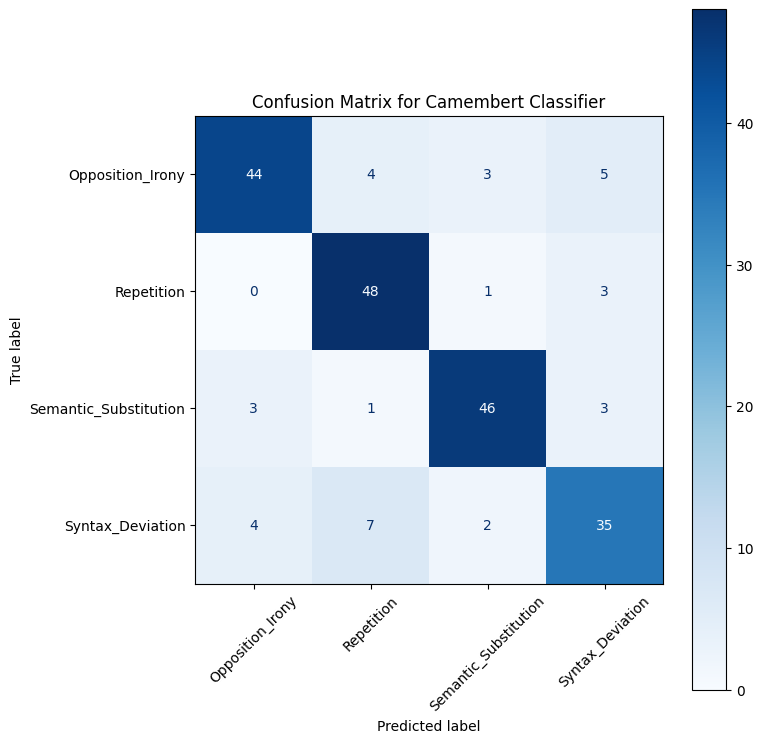

In [23]:
from transformers import CamembertTokenizer, CamembertForSequenceClassification
import torch
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

texts_train, texts_test, y_train, y_test = train_test_split(
    raw_texts, encoded_labels, test_size=0.2, random_state=42, stratify=encoded_labels
)

tokenizer = CamembertTokenizer.from_pretrained("camembert-base")
model_path = "./results_raw/checkpoint-315"
model = CamembertForSequenceClassification.from_pretrained(model_path, local_files_only=True)
model.eval()

encodings = tokenizer(texts_test, truncation=True, padding=True, max_length=128, return_tensors="pt")

with torch.no_grad():
    outputs = model(**encodings)
    logits = outputs.logits
    y_pred = torch.argmax(logits, axis=1).cpu().numpy()

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.xticks(rotation=45)  
plt.title("Confusion Matrix for Camembert Classifier")
plt.tight_layout()
plt.show()


## Analyzing Misclassified Examples

In the next step, we will identify and review the specific texts that our CamemBERT model misclassified. This helps us go beyond overall accuracy metrics to understand where and why the model struggles. By examining these errors, we can uncover patterns or challenges in the data, which informs improvements in preprocessing, model tuning, or data collection. This practical error analysis is a key part of refining any machine learning system.


In [ ]:
# Find indices where prediction != true label
misclassified_indices = [i for i, (true, pred) in enumerate(zip(y_test, y_pred)) if true != pred]

print(f"Number of misclassified samples: {len(misclassified_indices)}")

# Show some misclassified examples with their true and predicted labels
for i in misclassified_indices[:10]:  # limit to first 10 examples
    print(f"Text: {texts_test[i]}")
    print(f"True label: {label_encoder.inverse_transform([y_test[i]])[0]}")
    print(f"Predicted label: {label_encoder.inverse_transform([y_pred[i]])[0]}")
    print("---")


Number of misclassified samples: 36
Text: Rester dans le paradis, et y devenir démon, rentrer dans l'enfer, et y devenir ange !
True label: Syntax_Deviation
Predicted label: Repetition
---
Text: Pourquoi moi ? Pourquoi maintenant ?
True label: Syntax_Deviation
Predicted label: Opposition_Irony
---
Text: Il était le plus sage des fous.
True label: Opposition_Irony
Predicted label: Semantic_Substitution
---
Text: Celui qui craint les eaux, qu’il demeure au rivage, / Celui qui craint les maux qu’on souffre pour aimer, / Qu’il ne se laisse pas à l’amour enflammer
True label: Repetition
Predicted label: Syntax_Deviation
---
Text: La nuit, tous les chats sont gris.
True label: Semantic_Substitution
Predicted label: Syntax_Deviation
---
Text: Le bonheur, un papillon insaisissable.
True label: Semantic_Substitution
Predicted label: Opposition_Irony
---
Text: La maison est muette. Les membres de la famille retiennent leur souffle pour respecter mon chagrin.
True label: Repetition
Predicted labe

## Analysis of Selected Misclassified Examples

Here are a few notable examples where the CamemBERT model made classification errors. Each example is translated into English with a brief explanation of why the misclassification may have occurred.

---

**Original (French):**  
*Rester dans le paradis, et y devenir démon, rentrer dans l'enfer, et y devenir ange !*  
**True label:** Syntax_Deviation  
**Predicted label:** Repetition  

**English translation:**  
*Stay in paradise and become a demon there, enter hell and become an angel there!*  

**Explanation:**  
The sentence plays with syntactic inversion and paradox, which fits Syntax Deviation. However, the repetitive structure ("et y devenir...") might have confused the model, leading it to classify as Repetition.

---

**Original:**  
*Il était le plus sage des fous.*  
**True label:** Opposition_Irony  
**Predicted label:** Semantic_Substitution  

**English translation:**  
*He was the wisest of fools.*  

**Explanation:**  
This oxymoron is a clear case of opposition and irony. The model likely focused on the contradictory meanings of “wise” and “fool,” misclassifying it as a semantic substitution (change of meaning), which is close but less precise.

---

**Original:**  
*La nuit, tous les chats sont gris.*  
**True label:** Semantic_Substitution  
**Predicted label:** Syntax_Deviation  

**English translation:**  
*At night, all cats are grey.*  

**Explanation:**  
This proverb substitutes literal meaning for a figurative one, making it Semantic Substitution. The model probably focused on the sentence form rather than the semantic twist.

---

**Original:**  
*Canicule en France : 12 départements en vigilance rouge.*  
**True label:** Syntax_Deviation  
**Predicted label:** Semantic_Substitution  

**English translation:**  
*Heatwave in France: 12 departments on red alert.*  

**Explanation:**  
A factual statement with unusual phrasing, labeled Syntax Deviation. The model misinterpreted it as Semantic Substitution, probably due to unfamiliar phrasing or contextual cues.

---

## Summary

Misclassifications often happen when different figures of speech overlap or are subtle. The model sometimes prioritizes sentence structure over meaning or vice versa, showing the complexity of fine-grained stylistic classification.

# Step 4 - Inference with CamemBERT Classifier

After training our CamemBERT model to recognize rhetorical figures (such as `Repetition`, `Opposition_Irony`, `Syntax_Deviation`, and `Semantic_Substitution`), we now want to use it in a real-world scenario.

The goal of this section is to **load the trained model** and use it to **classify new, unseen sentences** based on their rhetorical figure. This can be useful, for example, in literary analysis or educational tools.

We define a function `classify_text` that:
1. Takes a French sentence as input.
2. Tokenizes the sentence using the CamemBERT tokenizer.
3. Passes it through the trained model.
4. Outputs the predicted rhetorical category label.

This allows us to interactively test the classifier on any input sentence in French.

In [17]:
from transformers import CamembertTokenizer, CamembertForSequenceClassification
import torch

model_path = "./results_raw/checkpoint-315"
tokenizer = CamembertTokenizer.from_pretrained("camembert-base")
model = CamembertForSequenceClassification.from_pretrained(model_path, local_files_only=True)

model.eval()

def classify_text(text, tokenizer, model, label_encoder):
    
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class_id = torch.argmax(logits, dim=1).item()
    
    return label_encoder.inverse_transform([predicted_class_id])[0]


## Testing the CamemBERT Classifier with Translated Sentences

This notebook demonstrates how we can evaluate a CamemBERT-based classifier on translated literary quotes that illustrate different rhetorical figures.

### Example 2: Syntax Deviation

**English Quote:**  
*"To be, or not to be, that is the question."* — *Shakespeare*

**French Translation:**  
*"Être ou ne pas être, telle est la question."*

**Expected Label:** `Opposition_Irony`

These examples can be passed into the classifier like this:


In [19]:
test_sentence = "Être ou ne pas être, telle est la question."
predicted_label = classify_text(test_sentence, tokenizer, model, label_encoder)
print("Predicted label:", predicted_label)

Predicted label: Opposition_Irony
